<img src="header_profi.png" align="left"/>

# Exercise GAN generated training data for MNIST classification 

The goal of this exercise is to evaluate the idea to generate additional trainings data for situations where either classes are imbalanced or some classes perform worse than others. The idea is e.g. described in [2].
First a basic GAN is trained and some examples are generated. Then a GAN for controlled generation of samples is implemented and samples are generated. Those samples are added to the training data of a simple MNIST classifier. The performence with and without the generated training data is evaluated. 

The sources of the first version of the GAN is borrowed from the great Jason Brownlee tutorial at [1]. 

- [1] https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
- [2] https://arxiv.org/abs/1810.10863



# Import modules

In [1]:
from numpy.random import seed
seed(42)
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import argmax
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.datasets import mnist
# source: https://github.com/tensorflow/tensorflow/issues/35407
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.models import load_model
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from numpy.random import randn
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# suppress some warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [3]:
# GPU support
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


2.0.0


In [6]:
prefix = 'results/15_'

In [16]:
latent_dim = 15

# Basic GAN

First lets play with a basic GAN implementation.

## Define generator and discriminator models

In [9]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    #opt = Adam(lr=0.0002, beta_1=0.5)
    opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    #opt = Adam(lr=0.0002, beta_1=0.5)
    opt = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


## Data generating and handling

In [10]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

## Plotting and quality results

In [11]:


# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = prefix + 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# plot performance and save model    
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100, save_model=False):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('accuracy real: {:.3f}, fake: {:.3f}'.format(acc_real, acc_fake))
    
    # save plot
    save_plot(x_fake, epoch)
    
    if save_model:
        # save the generator model tile file
        filename = prefix + 'generator_model_%03d.h5' % (epoch + 1)
        g_model.save(filename)
 

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256,debug=False):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print(".",end='')
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            # create mixed training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # create inverted labels for the fake samples !!!!
            y_gan = ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            if debug:
                print('epoch %d, %d/%d, discriminator loss = {:.3f}, generator loss = {:.3f}'.format (i+1, j+1, bat_per_epo, d_loss, g_loss))
        
        # evaluate the model performance, sometimes
        if (i+1) % 5 == 0:
            print("+")
            summarize_performance(i, g_model, d_model, dataset, latent_dim, save_model=False)

    # final summary and model
    summarize_performance(i, g_model, d_model, dataset, latent_dim, save_model=True)

In [ ]:
# size of the latent space
latent_dim = 15
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

## Generate example digits

After training the model, generate some example digits using the GAN model.

In [17]:
# example of loading the generator model and generating images
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

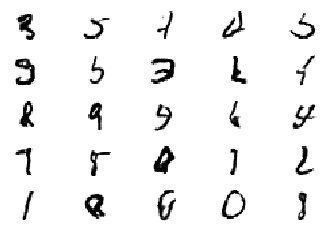

In [21]:
# load model
model = load_model(prefix+'generator_model_100.h5')
# generate images
latent_points = generate_latent_points(latent_dim, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

In [ ]:
# Generate samples of a specific class

# Task: InfoGAN and ACGAN

It seems that the images produced by the vanilla GAN start to converge after very long training. However, there is still the question open, how do we create selected digits using the generator model. Here, more advanced GAN types come into place. 

An immediate candidate would be the InfoGAN, this GAN type splits the generator input into a stochastic part and into a latent space vector with controlled semantics. This is what we want. A latent vector to control our desired output. However, it is still unclear, what the dimensions in the latent vector mean.

Another type of advanced GAN is the Conditional GAN. It works with the same idea, but the latent space is basically the label of the digit. So there we have a direct control over which digit we generate. So, our next step is to implement a special type of conditional GAN called ACGAN. Select one of [6],[7] or [8] sources for your implementation. Source [6] worked reasonable well.

**Notes**
- Start with a latent dim size of 25.
- Store your trained model using keras model.save method (acgan_generator.h5)
- Make sure that the generator model can later be used for sampling examples. Take a look at the next task, how the model is used there for sampling.


[5] https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/

[6] https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py

[7] https://github.com/lukedeo/keras-acgan/blob/master/mnist_acgan.py

[8] https://keras.io/examples/mnist_acgan/



In [22]:

# example taken from https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py


class ACGAN():
    
    def __init__(self,latent_dim=25):

        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,optimizer=optimizer,metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses, optimizer=optimizer)

        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        #model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes, activation="softmax")(features)
        return Model(img, [validity, label])

    
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        count = 0
        
        for epoch in range(epochs):

            #  Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 
            img_labels = y_train[idx]

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            #  Train Generator

            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

            # If at save interval => save generated image samples
            if (epoch) % sample_interval == 0:
                self.save_model()
                self.sample_images(epoch,count)
                count = count + 1


    def sample_images(self, epoch, count):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig( prefix + "image_%06d.png" % count )
        plt.close()

        
    def save_model(self):
        def save(model, model_name):
            model_path = prefix + "%s.json" % model_name
            weights_path = prefix + "%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        def save_keras(model,name):
            filename = prefix + 'acgan_' + name + '.h5'
            model.save(filename)
            
        save_keras(self.generator, "generator")
        save_keras(self.discriminator, "discriminator")




In [ ]:
# Result: create the model and train it

acgan = ACGAN(latent_dim=latent_dim)
acgan.train(epochs=14000, batch_size=32, sample_interval=200)

## Generate samples

Use the trained and stored model to samples some example images. 

In [23]:
# load ACGAN model
model = load_model(prefix+'acgan_generator.h5')

In [24]:
#
# Generate some images using the model
#
def sample_images(model,count,digit,latent_dim):
    noise = np.random.normal(0, 1, (count, latent_dim))
    sampled_labels = np.array( [digit] * count )
    
    # use the generator model with random prior plus label values
    gen_imgs = model.predict( [noise, sampled_labels] )
    
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(count)
    for i in range(count):
        axs[i].imshow(gen_imgs[i,:,:,0], cmap='gray')
        axs[i].axis('off')
    fig.savefig( prefix + "sample_image.png" )
    plt.close()
    
    sampled_labels = np.reshape(sampled_labels,(-1,1))
    return gen_imgs, sampled_labels

In [45]:
x_train_new, y_train_new = sample_images(model,500,8,latent_dim)

In [46]:
print(x_train_new.shape)
print(y_train_new.shape)

(500, 28, 28, 1)
(500, 1)


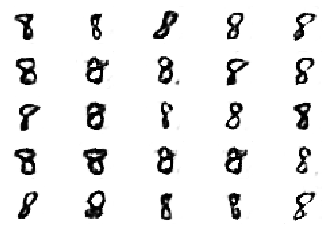

In [47]:
save_plot(x_train_new,5)

# Basic MNIST classifier

In [36]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [37]:
def build_mnist_model():
    seed(42)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    return model

In [38]:
mnist_model = build_mnist_model()

In [39]:
mnist_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = mnist_model.fit(x_train, y_train, batch_size=128, epochs=7 )

Epoch 1/7
60000/60000 [==============================] - 31s 512us/step - loss: 0.1707 - accuracy: 0.9485
Epoch 2/7
60000/60000 [==============================] - 33s 553us/step - loss: 0.0547 - accuracy: 0.9835
Epoch 3/7
60000/60000 [==============================] - 30s 502us/step - loss: 0.0359 - accuracy: 0.9892
Epoch 4/7
60000/60000 [==============================] - 30s 492us/step - loss: 0.0237 - accuracy: 0.9928
Epoch 5/7
60000/60000 [==============================] - 31s 518us/step - loss: 0.0158 - accuracy: 0.9955
Epoch 6/7
60000/60000 [==============================] - 30s 504us/step - loss: 0.0127 - accuracy: 0.9962
Epoch 7/7
60000/60000 [==============================] - 32s 528us/step - loss: 0.0090 - accuracy: 0.9973


## Performance

In [41]:
_, acc = mnist_model.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98690


## Find the worst class 

Find out which digit class has the most errors in classification. Print a histogram of errors for each class. You can also plot a confusion matrix of the errors.

In [42]:
# Result: plot histogram of errors

In [43]:
def count_plot_errors(model):
    errorCount = 0
    errorCountDistribution = [0] * 10
    for i in range(x_test.shape[0]):
        correctClass = argmax(y_test[i])
        image = x_test[i].reshape((1,28,28,1))
        prediction = model.predict_classes([image])
        predictedClass = prediction[0]
        if predictedClass != correctClass:
            errorCount+= 1
            errorCountDistribution[correctClass] = errorCountDistribution[correctClass] + 1
            
    class_pos = np.arange(10)
    plt.bar(class_pos, errorCountDistribution, align='center', alpha=0.5)
    plt.xlabel(class_pos)
    plt.ylabel('Counts')
    plt.title('Error count per digit class')
    plt.show()                

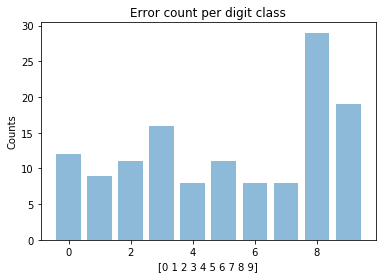

In [44]:
count_plot_errors(mnist_model)

In [ ]:
# Result: the worst class is ...

## Extended training set with samples of the worst class 

Now, since we know the worst class, we can go back to the ACGAN and generate some samples (e.g. 100) of this class and add them to the training data.

In [48]:
x_train_ext = np.concatenate([x_train, x_train_new], axis=0)

In [49]:
y_train_new = to_categorical(y_train_new, num_classes=10)
y_train_ext = np.concatenate([y_train, y_train_new], axis=0)

In [50]:
mnist_model2 = build_mnist_model()

In [53]:
mnist_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = mnist_model2.fit(x_train_ext, y_train_ext, batch_size=128, epochs=7 )

Epoch 1/7
60500/60500 [==============================] - 30s 502us/step - loss: 0.1875 - accuracy: 0.9440
Epoch 2/7
60500/60500 [==============================] - 31s 512us/step - loss: 0.0578 - accuracy: 0.9825
Epoch 3/7
60500/60500 [==============================] - 31s 506us/step - loss: 0.0364 - accuracy: 0.9891
Epoch 4/7
60500/60500 [==============================] - 31s 509us/step - loss: 0.0235 - accuracy: 0.9930
Epoch 5/7
60500/60500 [==============================] - 31s 509us/step - loss: 0.0171 - accuracy: 0.9946
Epoch 6/7
60500/60500 [==============================] - 31s 517us/step - loss: 0.0116 - accuracy: 0.9965
Epoch 7/7
60500/60500 [==============================] - 32s 521us/step - loss: 0.0082 - accuracy: 0.9977


## Evaluate performance of new model

Measure the performance of the new model and discuss the results. Has it gotten any better? Could it be that the improvement is smaller than the variance of the accuracy? Try several runs! What do you think?

In [54]:
_, acc = mnist_model2.evaluate(x_test, y_test, verbose=0)
print('accuracy {:.5f}'.format(acc))

accuracy 0.98510


In [ ]:
count_plot_errors(mnist_model2)